
# Import


In [42]:
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, classification_report

from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import TensorDataset, DataLoader

from gift_cnn import gift_cnn
from cnn_classifier import CNN

# Load dataset

In [48]:
dataset = np.load("dataset.npz")
X, y = dataset["X"], dataset["y"]

print("Number of images:", X.shape[0])
print("Number of labels:", y.shape[0])
print("Unique labels:", np.unique(y))


Number of images: 13067
Number of labels: 13067
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [49]:
X = X / 255.0 

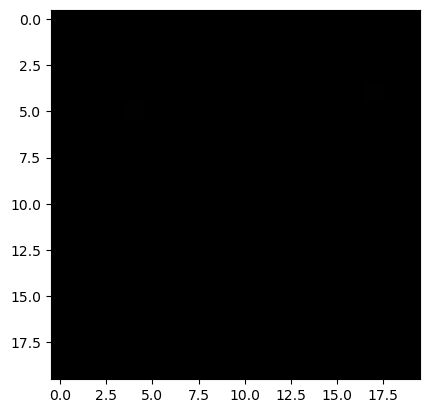

In [50]:
#vislualize

#chosen image
k=10

shape = (X[k].reshape(20,20))
flatten = shape.flatten()


plt.imshow(shape, vmin=0, vmax=255, cmap="gray")
plt.show()

# Class distribution

In [51]:
def class_dist(y):
    unique, counts = np.unique(y, return_counts=True)
    plt.bar(unique, counts)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.title("Class distribution")
    plt.show()

In [41]:
def blurred():
    means = []
    for label in range(15):
        means.append(X[y == label].mean(axis=0))

    fig, axes = plt.subplots(3, 5, figsize=(8, 5))
    for i, ax in enumerate(axes.flat):
        ax.imshow(means[i].reshape(20, 20), cmap='gray')
        ax.set_title(f"Class {i}")
        ax.axis('off')
    plt.show()
    #If averages look very similar → classes are visually similar → use a deeper CNN.

    # If they’re very distinct → your model can be smaller (simpler CNN).

# CNN

In [52]:
dataset = np.load("dataset.npz")
X, y = dataset["X"], dataset["y"]
X = X / 255.0
X_tensor = torch.tensor(X, dtype=torch.float32).view(-1, 1, 20, 20)
y_tensor = torch.tensor(y, dtype=torch.long)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, stratify=y_tensor
)

train_loader = DataLoader(TensorDataset(X_trainval, y_trainval), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=32, shuffle=False)


In [ ]:
param_grid = {
    "learning_rate": [0.001, 0.0005],
    "dropout_rate": [0.25, 0.5],
    "batch_size": [32, 64],
    "weight_decay": [0, 1e-4]
}


grid = GridSearchCV(CNN(), param_grid, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=3)
grid.fit(X_trainval, y_trainval)

print("Best parameters:", grid.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV 2/3] END batch_size=32, dropout_rate=0.25, learning_rate=0.001, weight_decay=0;, score=0.835 total time= 1.7min
[CV 2/3] END batch_size=32, dropout_rate=0.25, learning_rate=0.0005, weight_decay=0;, score=0.832 total time= 1.7min
[CV 1/3] END batch_size=32, dropout_rate=0.25, learning_rate=0.001, weight_decay=0;, score=0.832 total time= 1.7min
[CV 1/3] END batch_size=32, dropout_rate=0.25, learning_rate=0.0005, weight_decay=0;, score=0.827 total time= 1.7min
[CV 1/3] END batch_size=32, dropout_rate=0.25, learning_rate=0.001, weight_decay=0.0001;, score=0.824 total time= 1.7min
[CV 3/3] END batch_size=32, dropout_rate=0.25, learning_rate=0.001, weight_decay=0;, score=0.834 total time= 1.7min
[CV 3/3] END batch_size=32, dropout_rate=0.25, learning_rate=0.001, weight_decay=0.0001;, score=0.831 total time= 1.7min
[CV 2/3] END batch_size=32, dropout_rate=0.25, learning_rate=0.001, weight_decay=0.0001;, score=0.841 total time= 1

In [28]:
best_params = grid.best_params_

best_model = CNN(
    num_epochs=20,
    batch_size=best_params["batch_size"],
    learning_rate=best_params["learning_rate"],
    dropout_rate=best_params["dropout_rate"],
    weight_decay=best_params["weight_decay"],
    verbose=True
)

best_model.fit(X_trainval, y_trainval)


Epoch [1/20] - Loss: 1.7918, Val Acc: 68.53%
Epoch [2/20] - Loss: 1.1057, Val Acc: 75.23%
Epoch [3/20] - Loss: 0.9171, Val Acc: 77.19%
Epoch [4/20] - Loss: 0.8213, Val Acc: 78.24%
Epoch [5/20] - Loss: 0.7778, Val Acc: 79.44%
Epoch [6/20] - Loss: 0.7249, Val Acc: 82.26%
Epoch [7/20] - Loss: 0.6804, Val Acc: 82.21%
Epoch [8/20] - Loss: 0.6425, Val Acc: 83.02%
Epoch [9/20] - Loss: 0.6127, Val Acc: 83.79%
Epoch [10/20] - Loss: 0.5869, Val Acc: 83.26%
Epoch [11/20] - Loss: 0.5635, Val Acc: 84.74%
Epoch [12/20] - Loss: 0.5462, Val Acc: 84.17%
Epoch [13/20] - Loss: 0.5221, Val Acc: 85.08%
Epoch [14/20] - Loss: 0.4973, Val Acc: 84.31%
Epoch [15/20] - Loss: 0.4787, Val Acc: 85.80%
Epoch [16/20] - Loss: 0.4780, Val Acc: 85.65%
Epoch [17/20] - Loss: 0.4544, Val Acc: 83.79%
Epoch [18/20] - Loss: 0.4403, Val Acc: 85.37%
Epoch [19/20] - Loss: 0.4186, Val Acc: 85.51%
Epoch [20/20] - Loss: 0.4134, Val Acc: 85.03%


In [35]:
test_acc = best_model.compute_accuracy(test_loader)
y_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\nTest Accuracy: {test_acc * 100:.2f}%")
print(f"Weighted F1-score: {test_f1:.4f}")
print(classification_report(y_test, y_pred))


Test Accuracy: 82.75%
Weighted F1-score: 0.8259
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       109
           1       0.68      0.74      0.71       180
           2       0.96      0.91      0.94       161
           3       0.74      0.59      0.66        91
           4       0.66      0.58      0.62       204
           5       0.90      0.92      0.91       273
           6       0.90      0.91      0.91       172
           7       0.67      0.54      0.60       111
           8       0.94      0.95      0.94       178
           9       0.90      0.85      0.88       167
          10       0.87      0.82      0.84       156
          11       0.70      0.78      0.74       320
          12       0.79      0.81      0.80       140
          13       0.84      0.95      0.90       177
          14       1.00      1.00      1.00       175

    accuracy                           0.83      2614
   macro avg       0.83      0.

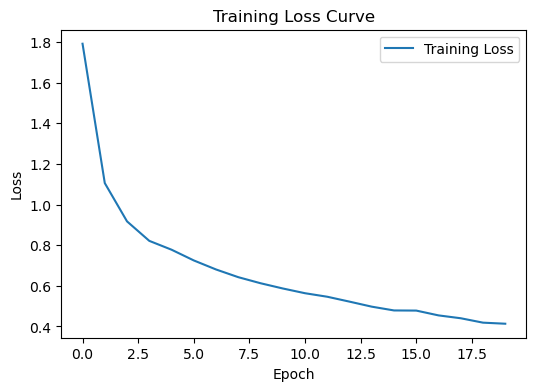

In [36]:
plt.figure(figsize=(6,4))
plt.plot(best_model.train_loss_history, label='Training Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training Loss Curve')
plt.legend()
plt.show()